## Определение перспективного тарифа для телеком компании

### Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<a id="data_description"></a>
### Описание данных
Таблица **users** (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

Таблица **calls** (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

Таблица **messages** (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Таблица **internet** (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Таблица **tariffs** (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Содержание

1. [Загрузка данных](#load_data)
2. [Предобработка данных](#data_preprocessing)
    * [Замена типов данных](#data_typization)
    * [Обработка дубликатов](#duplicates)
3. [Формирование сводной таблицы](#pivot_table)
4. [Анализ данных](#data_analysis)
5. [Проверка гипотез](#hypotesis_testing)
6. [Заключение](#conclusion)

<a id="load_data"></a>
### 1. Загрузка данных.

Импортируем необходимые библиотеки и загрузим данные. При чтении csv-файлов будем использовать автоматическое определение разделителя с помощью движка python.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display
from scipy import stats as st


calls_df = pd.read_csv('datasets/calls.csv', sep=None, engine='python')
internet_df = pd.read_csv('datasets/internet.csv', sep=None, engine='python')
messages_df = pd.read_csv('datasets/messages.csv', sep=None, engine='python')
tariffs_df = pd.read_csv('datasets/tariffs.csv', sep=None, engine='python')
users_df = pd.read_csv('datasets/users.csv', sep=None, engine='python', encoding='utf-8')

Посмотрим на первые записи датафреймов.

In [2]:
for df in [calls_df, internet_df, messages_df, tariffs_df, users_df]:
    display(df.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Данные загружены корректно. Заметен столбец без названия "Unamed: 0" в таблице интернет.  
Проверим таблицы на отсутствие данных и соответствие типов.

In [3]:
for df in [calls_df, internet_df, messages_df, tariffs_df, users_df]:
    display(df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 22.2 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.4 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 364.0 bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 229.6 KB


None

Все столбцы с датами необходимо будет привести к типу *datetime64*. Пропущенных данных кроме столбца '*churn_date*' нет, объяснение отсутствия даты прекращения пользования тарифом есть в [описании данных](#data_description).

Проанализируем содержимое столбцов более детально: для количественных признаков выведем их статистики и распределение, для категориальных - уникальные значения и их количество.

id
1133_180    1
1284_500    1
1491_159    1
1251_61     1
1391_228    1
           ..
1175_7      1
1459_10     1
1435_23     1
1021_924    1
1433_372    1
Name: id, Length: 202607, dtype: int64

call_date
2018-12-31    1435
2018-12-29    1202
2018-12-30    1192
2018-12-22    1158
2018-12-26    1149
              ... 
2018-01-05      20
2018-01-07      18
2018-01-02       9
2018-01-03       7
2018-01-01       5
Name: call_date, Length: 365, dtype: int64

duration
count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64
user_id
count    202607.000000
mean       1253.940619
std         144.722751
min        1000.000000
25%        1126.000000
50%        1260.000000
75%        1379.000000
max        1499.000000
Name: user_id, dtype: float64


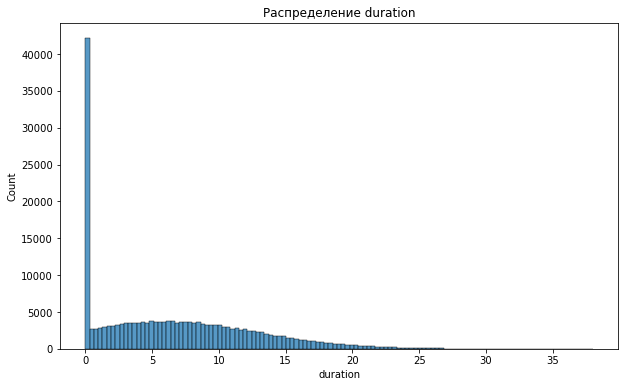

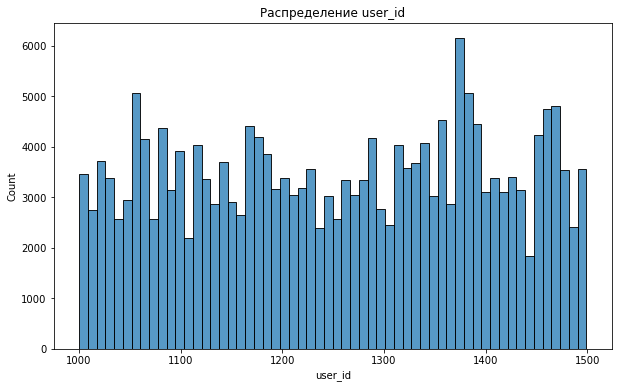

In [4]:
def info(data):
    """
    Функция пробегает по признакам датафрейма и если тип у признака object,
    то выводит уникальные значения и их количество, в противном случае 
    оценивается распределение
    
    """
    for column in data.columns:
        if data[column].dtype == 'object':
            print(column)
            print(data[column].value_counts())
            print()
        else:
            
            print(column)
            print(data[column].describe())
            plt.figure(figsize=(10, 6))
            sns.histplot(data[column])
            plt.title('Распределение '+ column);
            
info(calls_df)

В таблице **calls** заметно большое число записей со сверхкороткой длительностью звонков (скорее всего все = 0), что похоже на автодозвон, плата за который не должна быть взята.

Unnamed: 0
count    149396.000000
mean      74697.500000
std       43127.054745
min           0.000000
25%       37348.750000
50%       74697.500000
75%      112046.250000
max      149395.000000
Name: Unnamed: 0, dtype: float64
id
1102_217    1
1243_251    1
1061_140    1
1049_33     1
1344_69     1
           ..
1178_303    1
1225_83     1
1007_260    1
1436_318    1
1433_372    1
Name: id, Length: 149396, dtype: int64

mb_used
count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64
session_date
2018-12-31    1057
2018-12-30     903
2018-12-25     859
2018-12-26     844
2018-12-22     834
              ... 
2018-01-05      14
2018-01-04       9
2018-01-03       6
2018-01-01       3
2018-01-02       3
Name: session_date, Length: 365, dtype: int64

user_id
count    149396.000000
mean       1252.099842
std         144.050823
min    

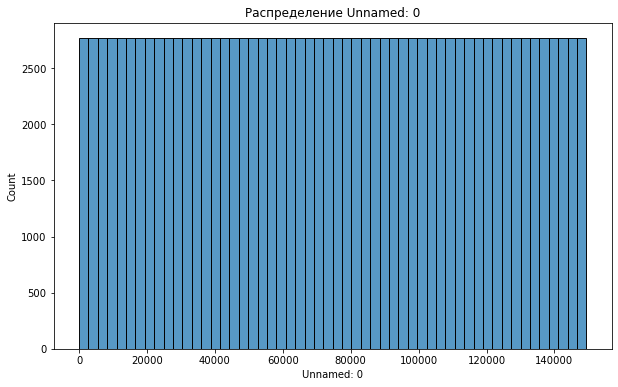

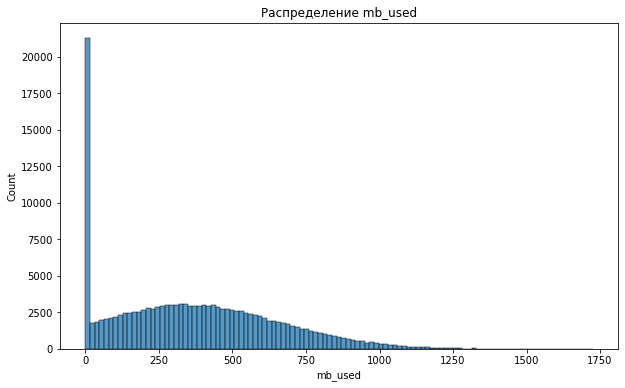

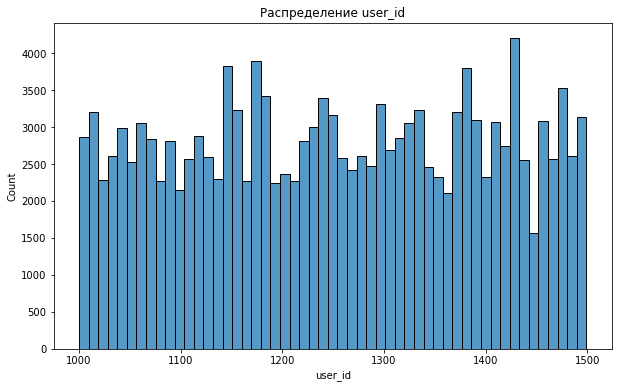

In [5]:
info(internet_df)

В таблице **internet** также видно наличие большого числа записей с 0 Мб объёма потраченного интернет-трафика, что вряд ли является неявным пропуском, а скорее имеет такой же характер, как и в случае с длительностью звонков. В целом графики длительности звонков и потраченного интернет-трафика за сессию очень похожи между собой. Данные в столбце '*Unnamed: 0*', похоже, являются копией индексов датафрейма.

id
1347_211    1
1073_24     1
1091_196    1
1314_236    1
1338_57     1
           ..
1356_635    1
1250_116    1
1056_145    1
1102_201    1
1433_372    1
Name: id, Length: 123036, dtype: int64

message_date
2018-12-31    859
2018-12-30    765
2018-12-21    712
2018-12-29    702
2018-12-26    699
             ... 
2018-01-11     12
2018-01-04     10
2018-01-05     10
2018-01-02     10
2018-01-03      4
Name: message_date, Length: 364, dtype: int64

user_id
count    123036.000000
mean       1256.989410
std         143.523967
min        1000.000000
25%        1134.000000
50%        1271.000000
75%        1381.000000
max        1499.000000
Name: user_id, dtype: float64


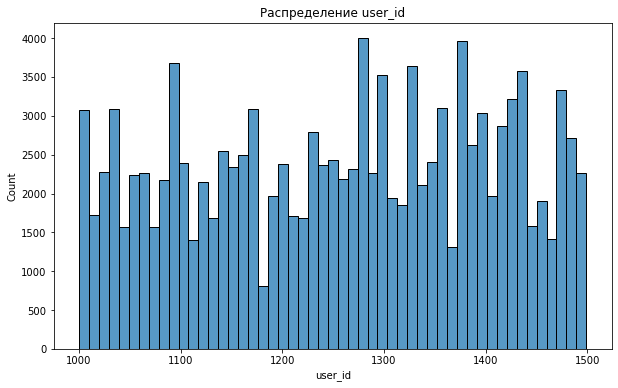

In [6]:
info(messages_df)

В таблице **messages** всё нормально.

user_id
count     500.000000
mean     1249.500000
std       144.481833
min      1000.000000
25%      1124.750000
50%      1249.500000
75%      1374.250000
max      1499.000000
Name: user_id, dtype: float64
age
count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64
churn_date
2018-10-03    2
2018-12-09    2
2018-10-14    2
2018-12-21    2
2018-12-03    2
2018-10-05    1
2018-11-26    1
2018-10-25    1
2018-11-07    1
2018-12-30    1
2018-12-25    1
2018-10-04    1
2018-12-26    1
2018-11-27    1
2018-12-20    1
2018-09-26    1
2018-12-16    1
2018-10-28    1
2018-12-23    1
2018-12-18    1
2018-11-13    1
2018-11-30    1
2018-12-11    1
2018-11-22    1
2018-12-24    1
2018-09-02    1
2018-08-17    1
2018-11-16    1
2018-09-27    1
2018-12-14    1
2018-08-31    1
2018-10-27    1
2018-11-21    1
Name: churn_date, dtype: int64

city
Москва             99
Санкт-Петербур

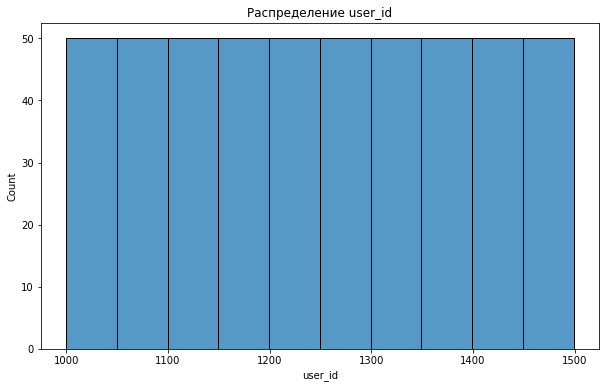

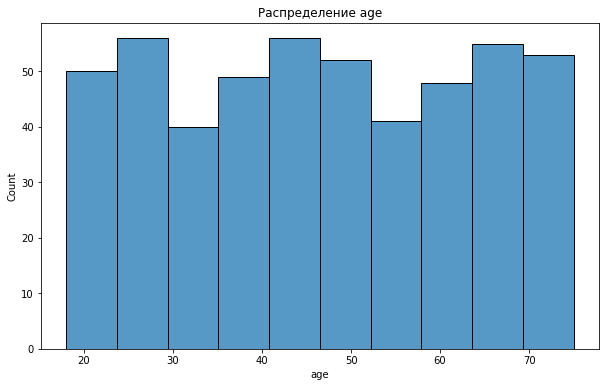

In [7]:
info(users_df)

В таблице **users** следует проверить города, имена и фамилии на возможные неявные дубликаты.

### Вывод

* Исходный набор данных представляет собой пять таблиц:
    * **calls**, состоящую из 4 столбцов-признаков и 202607 строк
    * **internet**, состоящую из 5 столбцов-признаков и 149396 строк
    * **messages**, состоящую из 3 столбцов-признаков и 123036 строк
    * **tariffs**, состоящую из 8 столбцов-признаков и 2 строк
    * **users**, состоящую из 8 столбцов-признаков и 500 строк
* Названия столбцов корректны (написаны одним стилем, латиницей, без пробелов).
* В таблице **internet** столбец без названия "Unamed: 0".
* Все столбцы с датами необходимо будет привести к типу *datetime64*.
* Пропущенных данных кроме столбца '*churn_date*' (таблица **users**) нет, объяснение отсутствия даты прекращения пользования тарифом есть в [описании данных](#data_description).
* В таблице **users** следует проверить города, имена и фамилии на возможные неявные дубликаты.

<a id="data_preprocessing"></a>
### 2. Предобработка данных

<a id="data_typization"></a>
### Замена типов данных

Заменим тип данных в столбцах с датами на datetime64.

In [8]:
for df in [calls_df, internet_df, messages_df, tariffs_df, users_df]:
    date_cols = [col for col in df.columns if 'date' in col]
    for date_col in date_cols:
        df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d')
        print('Столбец:', date_col, '\tТип данных:', df[date_col].dtype)

Столбец: call_date 	Тип данных: datetime64[ns]
Столбец: session_date 	Тип данных: datetime64[ns]
Столбец: message_date 	Тип данных: datetime64[ns]
Столбец: churn_date 	Тип данных: datetime64[ns]
Столбец: reg_date 	Тип данных: datetime64[ns]


<a id="duplicates"></a>
### Обработка дубликатов

Удалим столбец '*Unnamed: 0*', так как он дублирует индексы таблицы **internet**.

In [9]:
internet_df.drop(columns='Unnamed: 0', inplace=True)
internet_df.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Проверим на возможные неявные дубликаты столбцы '*city*', '*first_name*' и '*last_name*' таблицы **users**. В качестве критерия отбора слов, отличающихся на 1 символ, применим расстояние Левенштейна.

In [10]:
import nltk


def find_implicit_duplicates(data, edit_distance=1):
    data = set(data)
    implicit_duplicates = [
        [
            value2
            for value2 in list(data - set([value1]))
            if nltk.edit_distance(value1, value2) <= edit_distance and value2 != ''
        ]
        for value1 in data
    ]
    
    implicit_duplicates = [
        item[0]
        for item in implicit_duplicates
        if len(item) != 0
    ]
    
    print('Всего неявных дубликатов выявлено:', len(implicit_duplicates))
    print('\nСписок неявных дубликатов:\n', implicit_duplicates)
    return implicit_duplicates

    
city_duplicates = find_implicit_duplicates(users_df['city'])
fname_duplicates = find_implicit_duplicates(users_df['first_name'])
lname_duplicates = find_implicit_duplicates(users_df['last_name'])

Всего неявных дубликатов выявлено: 0

Список неявных дубликатов:
 []
Всего неявных дубликатов выявлено: 54

Список неявных дубликатов:
 ['Габриэль', 'Дана', 'Рустем', 'Мадина', 'Исак', 'Милена', 'Владислав', 'Дайна', 'Алина', 'Рустэм', 'Габриель', 'Юлий', 'Александра', 'Валерия', 'Лилия', 'Рем', 'Александр', 'Руслана', 'Алина', 'Лидия', 'Исаак', 'Евгений', 'Руслан', 'Эльга', 'Эльмира', 'Алла', 'Юна', 'Ренат', 'Валерий', 'Ренат', 'Алина', 'Марина', 'Юлий', 'Элла', 'Рустэм', 'Эльвира', 'Эльза', 'Радим', 'Марина', 'Яна', 'Алина', 'Инга', 'Наида', 'Рэм', 'Алёна', 'Ринат', 'Марина', 'Милана', 'Саида', 'Юрий', 'Владислава', 'Инна', 'Евгения', 'Вадим']
Всего неявных дубликатов выявлено: 138

Список неявных дубликатов:
 ['Алешин', 'Трофимов', 'Корольков', 'Селезнев', 'Козлов', 'Андропова', 'Алёшкова', 'Крюков', 'Крюков', 'Ильина', 'Костина', 'Жарова', 'Григорьева', 'Сазонова', 'Нестеров', 'Белякова', 'Тимофеев', 'Афинин', 'Карасева', 'Воронина', 'Шарапова', 'Зубков', 'Родионов', 'Аничкина', 'В

Среди городов дубликатов не выявлено; среди имён и фамилий есть много похожих и отличающихся одной буквой, но все они существуют и опечаток, похоже, нет.  
Проверим таблицы на явные дубликаты.

In [11]:
df_dict = {
    'calls': calls_df,
    'internet': internet_df,
    'messages': messages_df,
    'tariffs': tariffs_df,
    'users': users_df
}

for df_name, df in df_dict.items():
    print('Дубликатов в таблице {}: {}'.format(df_name, df.duplicated().sum()))

Дубликатов в таблице calls: 0
Дубликатов в таблице internet: 0
Дубликатов в таблице messages: 0
Дубликатов в таблице tariffs: 0
Дубликатов в таблице users: 0


Дубликатов нет.

<a id="pivot_table"></a>
### Формирование сводной таблицы

Начнём формирование сводной таблицы, в которой отобразим для каждого пользователя информацию о количестве звонков, потраченных минут, отправленных СМС, израсходованных МБ и тратах за каждый месяц. Начнём с количества звонков и минут. Добавим в таблицу **calls** столбцы с месяцем и округлённым значением минут и посчитаем количество совершённых звонков и минут в каждом месяце.

In [12]:
calls_df['call_month'] = calls_df['call_date'].dt.month
calls_df['round_duration'] = np.ceil(calls_df['duration'])

calls_pivot = calls_df.pivot_table(index=['user_id', 'call_month'], values='round_duration', aggfunc=['count', 'sum'])
calls_pivot

count            sum
                   round_duration round_duration
user_id call_month                              
1000    5                      22          159.0
        6                      43          172.0
        7                      47          340.0
        8                      52          408.0
        9                      58          466.0
...                           ...            ...
1498    10                     41          247.0
1499    9                       9           70.0
        10                     68          449.0
        11                     74          612.0
        12                     69          492.0

[3174 rows x 2 columns]

Теперь посчитаем таким же способом число СМС в каждом месяце, используя данные из таблицы **messages**.

In [13]:
messages_df['msg_month'] = messages_df['message_date'].dt.month
msg_pivot = messages_df.pivot_table(index=['user_id', 'msg_month'], values='id', aggfunc='count')
msg_pivot.columns = ['messages_per_month']
msg_pivot

messages_per_month
user_id msg_month                    
1000    5                          22
        6                          60
        7                          75
        8                          81
        9                          57
...                               ...
1498    10                         42
1499    9                          11
        10                         48
        11                         59
        12                         66

[2717 rows x 1 columns]

Теперь посчитаем количество МБ, потраченное в каждом месяце, используя данные из таблицы **internet**.

In [14]:
internet_df['session_month'] = internet_df['session_date'].dt.month

internet_df['mb_used'] = np.ceil(internet_df['mb_used'])

internet_pivot = internet_df.pivot_table(index=['user_id', 'session_month'], values='mb_used', aggfunc='sum')
internet_pivot.columns = ['mb_used_per_month']
internet_pivot

mb_used_per_month
user_id session_month                   
1000    5                         2256.0
        6                        23257.0
        7                        14016.0
        8                        14070.0
        9                        14581.0
...                                  ...
1498    10                       20604.0
1499    9                         1848.0
        10                       17809.0
        11                       17984.0
        12                       13077.0

[3203 rows x 1 columns]

Объединим датафреймы методом *join()* по мультииндексу и проверим наличие или отсутствие пропущенных значений.

In [15]:
pivot_table = (
    calls_pivot
    .join(msg_pivot, on=['user_id', 'call_month'], how='outer')
    .join(internet_pivot, on=['user_id', 'call_month'], how='outer')
)
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1476, 4)
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (count, round_duration)  3174 non-null   float64
 1   (sum, round_duration)    3174 non-null   float64
 2   messages_per_month       2717 non-null   float64
 3   mb_used_per_month        3203 non-null   float64
dtypes: float64(4)
memory usage: 130.4 KB


Заменим пропуски нулями и сбросим мультииндекс.

In [16]:
pivot_table.fillna(0, inplace=True)
pivot_table.reset_index(inplace=True)
pivot_table.head()

,user_id,call_month,"(count, round_duration)","(sum, round_duration)",messages_per_month,mb_used_per_month
0,1000,5,22.0,159.0,22.0,2256.0
1,1000,6,43.0,172.0,60.0,23257.0
2,1000,7,47.0,340.0,75.0,14016.0
3,1000,8,52.0,408.0,81.0,14070.0
4,1000,9,58.0,466.0,57.0,14581.0


Теперь приведём названия столбцов к удобному формату.

In [17]:
cols = pivot_table.columns.to_list()
cols[1] = 'month'
cols[2] = 'calls_per_month'
cols[3] = 'minutes_per_month'
pivot_table.columns = cols
pivot_table.head()

,user_id,month,calls_per_month,minutes_per_month,messages_per_month,mb_used_per_month
0,1000,5,22.0,159.0,22.0,2256.0
1,1000,6,43.0,172.0,60.0,23257.0
2,1000,7,47.0,340.0,75.0,14016.0
3,1000,8,52.0,408.0,81.0,14070.0
4,1000,9,58.0,466.0,57.0,14581.0


Проверим корректность замены пропущенных значений и типы данных на соответствие.

In [18]:
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             3214 non-null   int64  
 1   month               3214 non-null   int64  
 2   calls_per_month     3214 non-null   float64
 3   minutes_per_month   3214 non-null   float64
 4   messages_per_month  3214 non-null   float64
 5   mb_used_per_month   3214 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 150.8 KB


Заменим тип в столбцах '*calls_per_month*', '*minutes_per_month*' и '*messages_per_month*' на целочисленный.

In [19]:
pivot_table[['calls_per_month', 'minutes_per_month', 'messages_per_month']] =\
        pivot_table[['calls_per_month', 'minutes_per_month', 'messages_per_month']].astype('int64')
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             3214 non-null   int64  
 1   month               3214 non-null   int64  
 2   calls_per_month     3214 non-null   int64  
 3   minutes_per_month   3214 non-null   int64  
 4   messages_per_month  3214 non-null   int64  
 5   mb_used_per_month   3214 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 150.8 KB


Теперь присоединим столбец '*tariff*' из таблицы **users** с тарифами пользователей для того, чтобы было удобно считать месячную выручку с каждого пользователя.

In [20]:
pivot_table = pivot_table.merge(users_df[['user_id', 'tariff', 'city']], on='user_id', how='left')
pivot_table.head()

,user_id,month,calls_per_month,minutes_per_month,messages_per_month,mb_used_per_month,tariff,city
0,1000,5,22,159,22,2256.0,ultra,Краснодар
1,1000,6,43,172,60,23257.0,ultra,Краснодар
2,1000,7,47,340,75,14016.0,ultra,Краснодар
3,1000,8,52,408,81,14070.0,ultra,Краснодар
4,1000,9,58,466,57,14581.0,ultra,Краснодар


Наконец, посчитаем месчную выручку с каждого пользователя компании "Мегалайн" в 2018 году.

In [21]:
def calculate_month_revenue_from_user(row):
    tariff_info = tariffs_df.query('tariff_name == @row.tariff')
    revenue = tariff_info['rub_monthly_fee'].values[0]
    
    minutes_diff = (row['minutes_per_month'] - tariff_info['minutes_included']).values[0]
    msg_diff = (row['messages_per_month'] - tariff_info['messages_included']).values[0]
    mb_diff = (row['mb_used_per_month'] - tariff_info['mb_per_month_included']).values[0]
    
    if minutes_diff > 0:
        revenue += tariff_info['rub_per_minute'].values[0] * minutes_diff
    if msg_diff > 0:
        revenue += tariff_info['rub_per_message'].values[0] * msg_diff
    if mb_diff > 0:
        revenue += tariff_info['rub_per_gb'].values[0] * np.ceil(mb_diff / 1024)
    return revenue

pivot_table['month_revenue_from_user'] = pivot_table.apply(calculate_month_revenue_from_user, axis=1)
pivot_table.head()

,user_id,month,calls_per_month,minutes_per_month,messages_per_month,mb_used_per_month,tariff,city,month_revenue_from_user
0,1000,5,22,159,22,2256.0,ultra,Краснодар,1950.0
1,1000,6,43,172,60,23257.0,ultra,Краснодар,1950.0
2,1000,7,47,340,75,14016.0,ultra,Краснодар,1950.0
3,1000,8,52,408,81,14070.0,ultra,Краснодар,1950.0
4,1000,9,58,466,57,14581.0,ultra,Краснодар,1950.0


### Вывод

* Типы столбцов с датами были приведены к *datetime64*.
* Таблицы проверены на дубликаты (дубликатов не оказалось).
* Сформирована сводная таблица для анализа поведения каждого пользователя по месяцам со столбцами количества звонков, минут, СМС, МБ в месяц, тарифа, города пользователя и выручки с него.

<a id="data_analysis"></a>
### 3. Анализ данных.

Опишем поведение клиентов оператора, исходя из выборки. Выведем среднее, стандартное отклонение и дисперсию минут разговоров, СМС и использованных МБ в месяц для тарифов "smart" и "ultra".

In [22]:
req_cols = ['minutes_per_month', 'messages_per_month', 'mb_used_per_month']

for tariff_name in tariffs_df['tariff_name']:
    print('Базовые статистики по месяцам для тарифа', tariff_name)
    display(
        pivot_table
        .query('tariff == @tariff_name')[req_cols]
        .agg(func=['mean', 'std', np.var])
    )

Базовые статистики по месяцам для тарифа smart


,minutes_per_month,messages_per_month,mb_used_per_month
mean,417.934948,33.384029,1.622919e+04
std,190.313730,28.227876,5.877577e+03
var,36219.315784,796.812958,3.454591e+07


Базовые статистики по месяцам для тарифа ultra


,minutes_per_month,messages_per_month,mb_used_per_month
mean,526.623350,49.363452,1.948690e+04
std,317.606098,47.804457,1.009632e+04
var,100873.633397,2285.266143,1.019356e+08


По значениям видно, что пользователи тарифа "smart" в среднем тратят 418 минут на разговоры в месяц, 33 СМС и 16 ГБ. Пользователи тарифа "ultra" в среднем тратят 527 минут, 49 СМС и 19 ГБ в месяц. Не глядя на распределение, можно предположить, что пользователи тарифа "ultra" не используют большую часть пакетных СМС.  
Построим распределения данных параметров, совместив на одном графике оба тарифа.

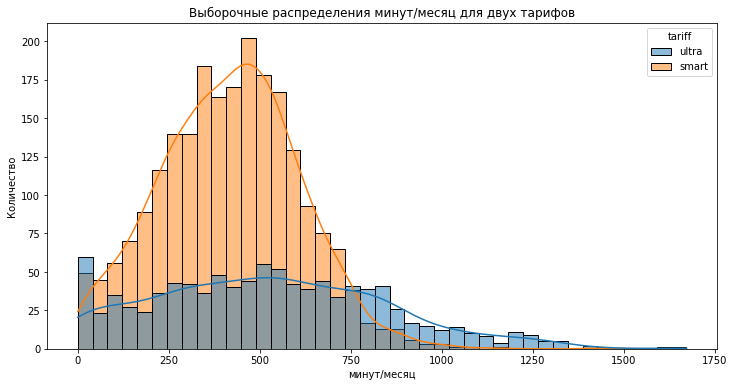

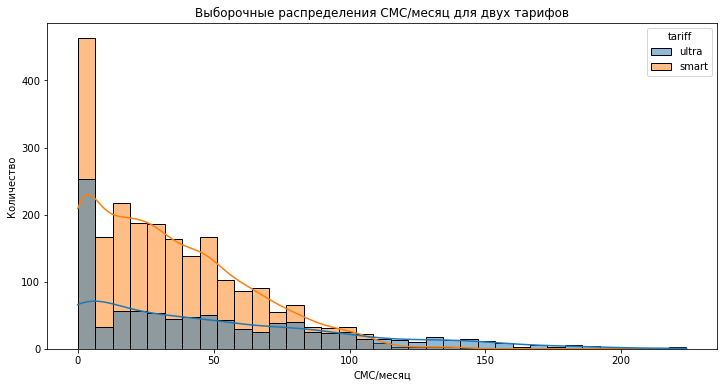

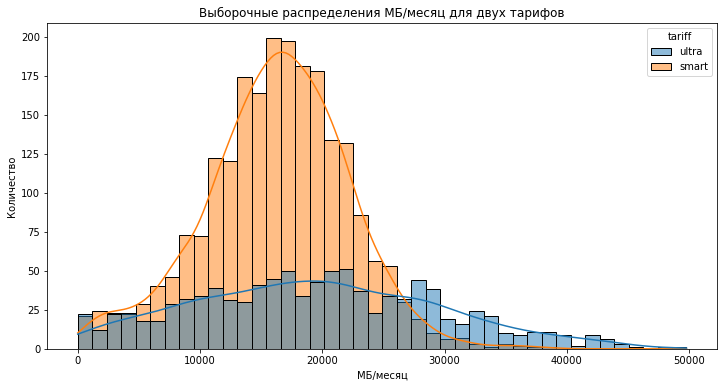

In [23]:
req_cols_rus = ['минут/месяц', 'СМС/месяц', 'МБ/месяц']

for i, col in enumerate(req_cols):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=pivot_table, x=col, hue='tariff', kde=True)
    plt.xlabel(req_cols_rus[i])
    plt.ylabel('Количество')
    plt.title('Выборочные распределения ' + req_cols_rus[i] + ' для двух тарифов');

По графикам заметно, что дисперсии параметров для пользователей тарифа "ultra" больше, чем тарифа "smart". Распределение минут и МБ отдалённо напоминают нормальное, а распределение СМС имеет перекос влево, что скорее всего свидетельствует о том, что пользователи сейчас в основном переписываются в мессенджерах, так как это более удобно.

Полезно оценить ещё среднее потребление на протяжении года или среднюю выручку.

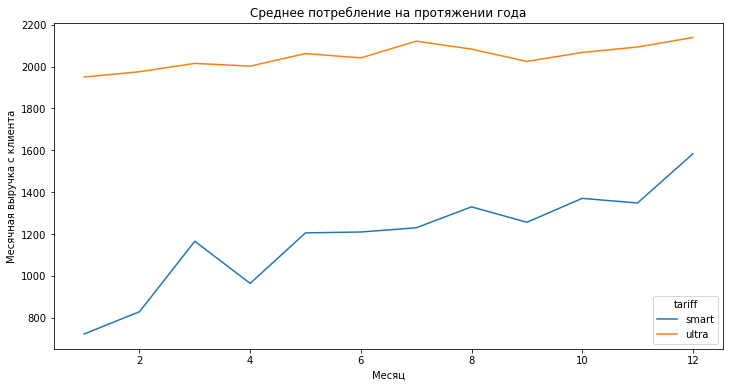

In [24]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='month',
    y='month_revenue_from_user',
    hue='tariff',
    data=pivot_table.pivot_table(
        index = ['tariff', 'month'],
        values = 'month_revenue_from_user',
        aggfunc = 'mean'
    ).reset_index()
)

plt.xlabel('Месяц')
plt.ylabel('Месячная выручка с клиента')
plt.title('Среднее потребление на протяжении года');

Видим, что средняя выручка более стабильна на Ультре, нежели на Смартe (неудивительно, ведь по Смарту непредсказуемые перерасходы).

Посмотрим sales_per_user.

In [25]:
piv = pivot_table.pivot_table(index = 'tariff', values = 'month_revenue_from_user', aggfunc = 'sum').reset_index()
piv['users'] = [351, 149]
piv['rev_per_user'] = piv['month_revenue_from_user'] / piv['users']
display(piv)

,tariff,month_revenue_from_user,users,rev_per_user
0,smart,2885751.0,351,8221.512821
1,ultra,2040000.0,149,13691.275168


Клиент Ультры прибыльнее, чем клиент Смарта

### Вывод

Из статистического описания видно, что среднее количество потраченных минут, СМС и МБ в месяц не сильно отличается для обоих тарифов, но дисперсия выше для тарифа "ультра". Распределения минут и мегабайт похожи на нормальное, в то же время распределение СМС скошено влево и больше похоже на экспоненциальное, чем на нормальное, что скорее всего свидетельствует о том, что пользователи сейчас в основном переписываются в мессенджерах. Cредняя выручка более стабильна на Ультре, нежели на Смартe, клиент Ультры прибыльнее, чем клиент Смарта.

<a id="hypotesis_testing"></a>
### 4. Проверка гипотез

Первый вопрос: различается ли средняя выручка пользователей тарифов «Ультра» и «Смарт».  
Для начала посмотрим на распределения месячной выручки для обоих тарифов.

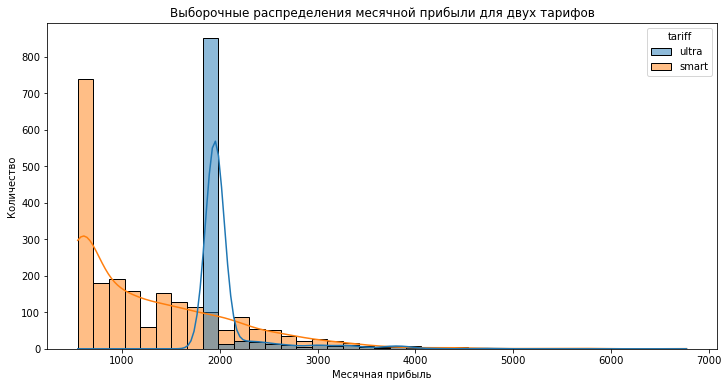

In [26]:
plt.figure(figsize=(12, 6))
sns.histplot(data=pivot_table, x='month_revenue_from_user', hue='tariff', kde=True)
plt.xlabel('Месячная прибыль')
plt.ylabel('Количество')
plt.title('Выборочные распределения месячной прибыли для двух тарифов');

Видно, что распределения не похожи на нормальные по своей природе: плата за тариф является минимальной выручкой с клиента и в то же время самым частым значением. Также видно, что пользователи тарифа "ультра" переплачивают только за интернет, в то время как пользователи тарифа "смарт" переплачивают и за минуты, и за интернет, причём некоторые платят больше пользователей тарифа "ультра".

Чтобы ответить на поставленный выше вопрос, сформулируем гипотезы:
* нулевая - средние выручки с клиента тарифов "смарт" и "ультра" равны
* альтернативная - средние выручки с клиента тарифов "смарт" и "ультра" не равны  

Уровень значимости зададим равным 0,1. Проверять гипотезу будем T-тестом для двух независимых выборок, так как траты пользователей каждого тарифа зависят только от использованных минут, СМС и МБ в месяц (случайная составляющая) и ценовой политики в отношении каждого тарифа (обычно цены фиксированы и представляют собой постоянную составляющую).

In [27]:
alpha = 0.1

sample = [
    pivot_table.query('tariff == @tariff_name')['month_revenue_from_user']
    for tariff_name in tariffs_df['tariff_name']
]
ttest_result = st.ttest_ind(sample[0], sample[1])

print('P-value равно', ttest_result.pvalue)

if ttest_result.pvalue < alpha:
    print('Различие выборочных средних считать статистически значимым, отвергаем нулевую гипотезу о равенстве средних')
else:
    print('Различие выборочных средних считать случайным, принимаем нулевую гипотезу')

P-value равно 2.9776448000521676e-158
Различие выборочных средних считать статистически значимым, отвергаем нулевую гипотезу о равенстве средних


Второй вопрос: отличается ли средняя выручка пользователей из Москвы от выручки пользователей из других регионов.  
Посмотрим на распределения месячной выручки для обеих групп.

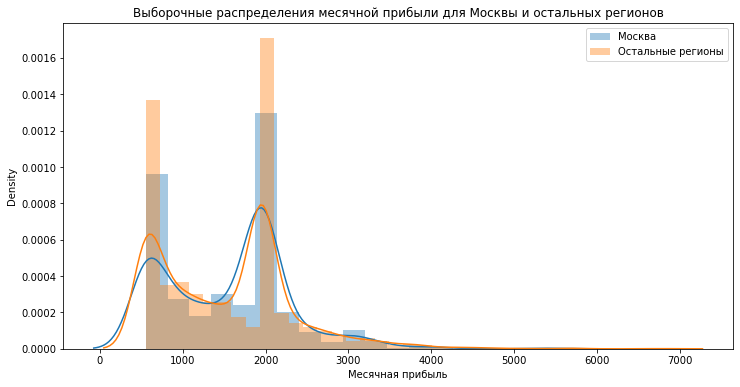

In [28]:
plt.figure(figsize=(12, 6))
ax = sns.distplot(pivot_table.query('city == "Москва"')['month_revenue_from_user'], label='Москва')
ax = sns.distplot(pivot_table.query('city != "Москва"')['month_revenue_from_user'], label='Остальные регионы')
plt.xlabel('Месячная прибыль')
plt.legend()
plt.title('Выборочные распределения месячной прибыли для Москвы и остальных регионов');

Здесь заметны две вершины у распределений, так как в обе группы попали пользователи из обоих тарифов, а значит, и обе моды по выручкам.

Сформулируем гипотезы:
* нулевая - средние выручки с клиента из Москвы и из других регионов равны
* альтернативная - средние выручки с клиента из Москвы и из других регионов не равны  

Уровень значимости зададим равным 0,1. Проверять гипотезу будем T-тестом для двух независимых выборок.

In [29]:
alpha = 0.1

sample = [
    pivot_table.query('city == "Москва"')['month_revenue_from_user'],
    pivot_table.query('city != "Москва"')['month_revenue_from_user']
]
ttest_result = st.ttest_ind(sample[0], sample[1])

print('P-value равно', ttest_result.pvalue)

if ttest_result.pvalue < alpha:
    print('Различие выборочных средних считать статистически значимым, отвергаем нулевую гипотезу о равенстве средних')
else:
    print('Различие выборочных средних считать случайным, принимаем нулевую гипотезу')

P-value равно 0.531666503831252
Различие выборочных средних считать случайным, принимаем нулевую гипотезу


### Вывод

Таким образом, гипотеза о равенстве средних выручек для двух тарифов была отвергнута и различие выборочных средних следует считать статистически значимым, то есть средняя выручка для двух тарифов скорее различается. Для пользователей же из Москвы средняя выручка скорее всего не отличается от выручки пользователей из других регионов, так как нулевая гипотеза о равенстве средних не была отвергнута.

<a id="conclusion"></a>
### Заключение

* Исходный набор данных представляет собой пять таблиц:
    * **calls**, состоящую из 4 столбцов-признаков и 202607 строк
    * **internet**, состоящую из 5 столбцов-признаков и 149396 строк
    * **messages**, состоящую из 3 столбцов-признаков и 123036 строк
    * **tariffs**, состоящую из 8 столбцов-признаков и 2 строк
    * **users**, состоящую из 8 столбцов-признаков и 500 строк

В ходе предобработки и подготовки данных проделано следующее:
* Типы столбцов с датами были приведены к *datetime64*.
* Таблицы проверены на дубликаты (дубликатов не оказалось).
* Сформирована сводная таблица для анализа поведения каждого пользователя по месяцам со столбцами количества звонков, минут, СМС, МБ в месяц, тарифа, города пользователя и выручки с него.

Из статистического анализа получены следующие выводы:
* Среднее количество потраченных минут, СМС и МБ в месяц не сильно отличается для обоих тарифов, но дисперсия выше для тарифа "ультра".
* Распределения минут и мегабайт похожи на нормальное, в то же время распределение СМС скошено влево и больше похоже на экспоненциальное, чем на нормальное, что скорее всего свидетельствует о том, что пользователи сейчас в основном переписываются в мессенджерах.
* Распределения выручек в месяц не похожи на нормальные по своей природе: плата за тариф является минимальной выручкой с клиента и в то же время самым частым значением. Также видно, что пользователи тарифа "ультра" переплачивают только за интернет, в то время как пользователи тарифа "смарт" переплачивают и за минуты, и за интернет, причём некоторые платят больше пользователей тарифа "ультра".

В результате проверки гипотез получены следующие результаты:
* Гипотеза о равенстве средних выручек для двух тарифов была отвергнута и различие выборочных средних следует считать статистически значимым, то есть средняя выручка для двух тарифов скорее различается.
* Для пользователей же из Москвы средняя выручка скорее всего не отличается от выручки пользователей из других регионов, так как нулевая гипотеза о равенстве средних не была отвергнута.